In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import yfinance as yf

start_date = '2019-03-01'
end_date = '2024-06-01'
symbol = 'AZN'

data = yf.download(symbol, start=start_date, end=end_date)
data.to_csv('AstraZeneca_data.csv')

[*********************100%%**********************]  1 of 1 completed


In [3]:
df = pd.read_csv('AstraZeneca_data.csv')
df1 = df.reset_index()['Open']

In [4]:
print(df1)

0       41.610001
1       41.730000
2       41.560001
3       42.360001
4       41.610001
          ...    
1318    78.129997
1319    77.779999
1320    76.129997
1321    76.620003
1322    77.309998
Name: Open, Length: 1323, dtype: float64


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [6]:
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [7]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
X_train

array([[0.11291459, 0.11573744, 0.11173842, ..., 0.08727356, 0.08468592,
        0.09056689],
       [0.11573744, 0.11173842, 0.1305575 , ..., 0.08468592, 0.09056689,
        0.07927544],
       [0.11173842, 0.1305575 , 0.11291459, ..., 0.09056689, 0.07927544,
        0.14090798],
       ...,
       [0.76946593, 0.78640315, 0.78334511, ..., 0.88073395, 0.88590923,
        0.88332159],
       [0.78640315, 0.78334511, 0.78146315, ..., 0.88590923, 0.88332159,
        0.9051988 ],
       [0.78334511, 0.78146315, 0.73276874, ..., 0.88332159, 0.9051988 ,
        0.8917902 ]])

In [9]:
model=RandomForestRegressor()

In [10]:
grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': np.arange(5, 25, 5),
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': np.arange(1, 3, 5, dtype=int),
    'bootstrap': [True, False],
    'random_state': [0, 20, 40, 60]
}

rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(X_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=0; total time=   2.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=0; total time=   2.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=60; total time=   1.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=0; total time=   2.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=60; total time=   1.4s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=1, min_samples_split=7, n_estimators=100, random_state=40; total time=   5.4s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=1, min_samples_split=7, n_estimators=100, random_state=40; total time=   5.5s
[CV] 

In [11]:
best_parameters

{'random_state': 60,
 'n_estimators': 50,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'bootstrap': True}

In [12]:
model = RandomForestRegressor(n_estimators=best_parameters['n_estimators'], random_state=best_parameters['random_state'], min_samples_split=best_parameters['min_samples_split'],
                              min_samples_leaf=best_parameters['min_samples_leaf'], max_depth=best_parameters['max_depth'], bootstrap=best_parameters['bootstrap'])
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=7, n_estimators=50,
                      random_state=60)

In [13]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [14]:
# Chuẩn hóa dữ liệu dự đoán
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [15]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))


In [16]:
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, y_pred), 4))
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, y_pred), 4))
print(f"Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_test, y_pred) * 100, 4)}%")

Root Mean Squared Error: 1.6182
Mean Squared Error: 2.6186
Mean Absolute Error: 1.2146
Mean Absolute Percentage Error: 1.7437%


In [17]:
# Dự báo cho 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1

lst_output = np.array(lst_output).reshape(-1, 1)


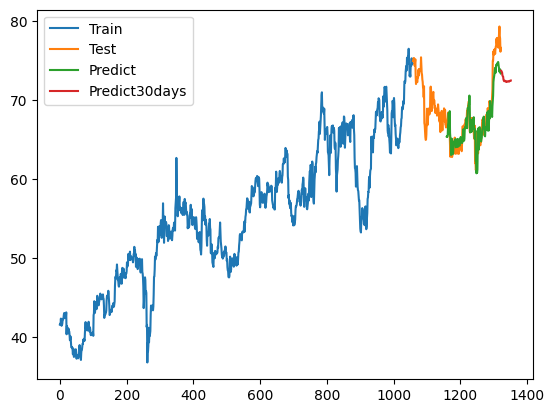

In [18]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()